<a href="https://colab.research.google.com/github/Vj-Ydv/trump_tweets_analysis/blob/master/Trump_Entire_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This cell connects to google drive, authenticates connection, and iterates over file list displaying each file's title and ID.
# it also imports and installs all the necessary libraries
!pip install -U -q PyDrive
!pip install -U -q wordcloud
!pip install -U -q bokeh
!pip install textblob
!pip install sklearn

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup

from wordcloud import WordCloud
from scipy.stats import hmean
from scipy.stats import norm
from pylab import *
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from time import time

  

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


# **Data Preprocessing**

In [ ]:
df_train = pd.read_csv('SC_Project/trump_tweets_with_sentiment.csv', encoding='latin-1')
df_train

,id_str,text,is_retweet,isDeleted,device,favorite_count,retweet_count,created_date,isFlagged,target,score
0,9.845500e+16,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,8/2/2011 18:07,f,NEGATIVE,0.713726
1,1.234650e+18,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,3/3/2020 1:34,f,POSITIVE,0.999789
2,1.218010e+18,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,1/17/2020 3:22,f,NEGATIVE,0.997674
3,1.304880e+18,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,9/12/2020 20:10,f,NEGATIVE,0.999798
4,1.218160e+18,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,1/17/2020 13:13,f,POSITIVE,0.988099
...,...,...,...,...,...,...,...,...,...,...,...
56566,1.319490e+18,RT @RandPaul: I donÃ¢ÂÂt know why @JoeBiden ...,t,f,Twitter for iPhone,0,20683,10/23/2020 3:46,f,NEGATIVE,0.995269
56567,1.319480e+18,RT @EliseStefanik: President @realDonaldTrump ...,t,f,Twitter for iPhone,0,9869,10/23/2020 3:42,f,POSITIVE,0.998308
56568,1.319440e+18,RT @TeamTrump: LIVE: Presidential Debate #Deba...,t,f,Twitter for iPhone,0,8197,10/23/2020 1:03,f,NEGATIVE,0.985231
56569,1.319380e+18,Just signed an order to support the workers of...,f,f,Twitter for iPhone,176289,36001,10/22/2020 21:04,f,NEGATIVE,0.995773


In [ ]:
#Strips emojis
def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :'),:D, : D, =)
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))|:\s?D | =\)', '', tweet)
    # Sad -- :-(, : (, :(, ):, )-: , :p
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)|:p', '', tweet)
    return tweet
  

In [ ]:
#clean data
url = re.compile(r"(?:(http[s]?://\S+)|((//)?(\w+\.)?\w+\.\w+/\S+))")
user_mention = re.compile(r"(?:(?<!\w)@\w+\b)")
number = re.compile(r"(?:\b\d+\b)")
repeated_char = '([a-zA-Z])\\1+'
length_repeated_char = '\\1\\1'

def clean(raw):
  #convert HTML encoding to text
  new_row = BeautifulSoup(raw, 'html.parser').get_text()
  
  #Change all text to lower case
  new_row = new_row.lower()
  
  #Replaces any url with class URL
  new_row = re.sub(url, '', new_row)
  
  #replace any @username with class USERNAME
  new_row = re.sub(user_mention, '', new_row)
  
  #Strips repeated chars
  new_row = re.sub(repeated_char, length_repeated_char, new_row)
  
  #Replaces #hashtag with hashtag
  new_row = re.sub(r'#(\S+)', r' \1 ', new_row)
  
  #Remove numbers
  new_row = re.sub(number, '', new_row)
  
  #decode text with 'utf-8-sig'
  try:
    temp_row = new_row.decode("utf-8-sig").replace(u"\ufffd", "?")     
  except:
    temp_row = new_row
  
  #Removes emojis
  new_row = handle_emojis(temp_row);
  
  return new_row

In [ ]:
clean_tweets_trump = []   

In [ ]:
#data preprocessing

chunks_range = [0,12000,24000,36000,56571] 
for i in range(chunks_range[3],chunks_range[4]):   #repeat for all range i.e. 0-1, 1-2, 2-3, 3-4
  clean_tweets_trump.append(clean(df_train['text'][i]))

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://t.co/iSFAokoIP7" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://t.co/ZQ0osiFEJQ" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://t.co/SmTkLPiBYD" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful S

In [ ]:
len(clean_tweets_trump)

56571

In [ ]:
df_train.columns

Index(['id_str', 'text', 'is_retweet', 'isDeleted', 'device', 'favorite_count',
       'retweet_count', 'created_date', 'isFlagged', 'target', 'score'],
      dtype='object')

In [ ]:
#save to csv file
clean_df = pd.DataFrame(clean_tweets_trump, columns=['text'])
clean_df['target'] = df_train.target
clean_df['target'] = df_train.target
clean_df['created_date'] = df_train.created_date
clean_df['is_retweet'] = df_train.is_retweet
clean_df['is_deleted'] = df_train.isDeleted
clean_df['device'] = df_train.device
clean_df['favorite_count'] = df_train.favorite_count
clean_df['retweet_count'] = df_train.retweet_count
clean_df['is_flagged'] = df_train.isFlagged
clean_df['score'] = df_train.score


In [ ]:
clean_df.columns

Index(['text', 'target', 'created_date', 'is_retweet', 'is_deleted', 'device',
       'favorite_count', 'retweet_count', 'is_flagged', 'score'],
      dtype='object')

In [ ]:
#clean_df.to_csv('SC_Project/trump_entire_tweet_clean.csv', encoding='utf-8')


In [ ]:
# upload file into pandas dataframe and drop unnecessary columns and neutral rows

# Using columns 1,2 because col 0 is the number of the row, could be changed if the row number is removed from the csv file.
df_trump = pd.read_csv('SC_Project/trump_entire_tweet_clean.csv', encoding='latin-1')
df_trump.head()

,text,target,created_date,is_retweet,is_deleted,device,favorite_count,retweet_count,is_flagged,score
0,you have very c...,Negative,2/20/2014 17:17,f,f,Twitter Web Client,50,23,f,0.949425
1,never learned so ...,Negative,1/31/2014 18:39,f,f,Twitter Web Client,29,21,f,0.997209
2,if you buy the team i...,Negative,4/21/2014 13:10,f,f,Twitter Web Client,26,13,f,0.988753
3,hey donald will ur new...,Negative,2/19/2014 15:58,f,f,Twitter Web Client,16,12,f,0.982411
4,the only way to fix hea...,Negative,1/6/2014 15:25,f,f,Twitter Web Client,52,27,f,0.998917


In [ ]:
df_trump['target'] = df_trump['target'].replace(['NEGATIVE'],'Negative')
df_trump['target'] = df_trump['target'].replace(['POSITIVE'],'Positive')

In [ ]:
df_trump.head()

,Unnamed: 0,text,target,created_date,is_retweet,is_deleted,device,favorite_count,retweet_count,is_flagged,score
0,0,republicans and democrats have both created ou...,Negative,8/2/2011 18:07,f,f,TweetDeck,49,255,f,0.713726
1,1,i was thrilled to be back in the great city of...,Positive,3/3/2020 1:34,f,f,Twitter for iPhone,73748,17404,f,0.999789
2,2,rt : read: letter to surveillance court obtain...,Negative,1/17/2020 3:22,t,f,Twitter for iPhone,0,7396,f,0.997674
3,3,the unsolicited mail in ballot scam is a major...,Negative,9/12/2020 20:10,f,f,Twitter for iPhone,80527,23502,f,0.999798
4,4,rt : very friendly telling of events here abou...,Positive,1/17/2020 13:13,t,f,Twitter for iPhone,0,9081,f,0.988099


In [ ]:
df_trump['text']=df_trump['text'].fillna(' ')
#df.dropna(axis=0, inplace=True)


In [ ]:
df_trump['text']=df_trump['text'].str.encode('ascii', 'ignore').str.decode('ascii')


In [ ]:
# Checking read cleaned file info if there are any null entries (found none) or white space
df_trump.info()
df_trump['text'] = df_trump['text'].str.strip()
df_trump.drop(df_trump[df_trump.text == ''].index, inplace=True)
df_trump

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56571 entries, 0 to 56570
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      56571 non-null  int64  
 1   text            56571 non-null  object 
 2   target          56571 non-null  object 
 3   created_date    56571 non-null  object 
 4   is_retweet      56571 non-null  object 
 5   is_deleted      56571 non-null  object 
 6   device          56571 non-null  object 
 7   favorite_count  56571 non-null  int64  
 8   retweet_count   56571 non-null  int64  
 9   is_flagged      56571 non-null  object 
 10  score           56571 non-null  float64
dtypes: float64(1), int64(3), object(7)
memory usage: 4.7+ MB


,Unnamed: 0,text,target,created_date,is_retweet,is_deleted,device,favorite_count,retweet_count,is_flagged,score
0,0,republicans and democrats have both created ou...,Negative,8/2/2011 18:07,f,f,TweetDeck,49,255,f,0.713726
1,1,i was thrilled to be back in the great city of...,Positive,3/3/2020 1:34,f,f,Twitter for iPhone,73748,17404,f,0.999789
2,2,rt : read: letter to surveillance court obtain...,Negative,1/17/2020 3:22,t,f,Twitter for iPhone,0,7396,f,0.997674
3,3,the unsolicited mail in ballot scam is a major...,Negative,9/12/2020 20:10,f,f,Twitter for iPhone,80527,23502,f,0.999798
4,4,rt : very friendly telling of events here abou...,Positive,1/17/2020 13:13,t,f,Twitter for iPhone,0,9081,f,0.988099
...,...,...,...,...,...,...,...,...,...,...,...
56566,56566,rt : i dont know why thinks he can continue t...,Negative,10/23/2020 3:46,t,f,Twitter for iPhone,0,20683,f,0.995269
56567,56567,rt : president excels at communicating direct...,Positive,10/23/2020 3:42,t,f,Twitter for iPhone,0,9869,f,0.998308
56568,56568,rt : live: presidential debate debates2020 \n...,Negative,10/23/2020 1:03,t,f,Twitter for iPhone,0,8197,f,0.985231
56569,56569,just signed an order to support the workers of...,Negative,10/22/2020 21:04,f,f,Twitter for iPhone,176289,36001,f,0.995773


In [ ]:
df_trump=df_trump.drop_duplicates( "text" , keep='first')
df_trump

,Unnamed: 0,text,target,created_date,is_retweet,is_deleted,device,favorite_count,retweet_count,is_flagged,score
0,0,republicans and democrats have both created ou...,Negative,8/2/2011 18:07,f,f,TweetDeck,49,255,f,0.713726
1,1,i was thrilled to be back in the great city of...,Positive,3/3/2020 1:34,f,f,Twitter for iPhone,73748,17404,f,0.999789
2,2,rt : read: letter to surveillance court obtain...,Negative,1/17/2020 3:22,t,f,Twitter for iPhone,0,7396,f,0.997674
3,3,the unsolicited mail in ballot scam is a major...,Negative,9/12/2020 20:10,f,f,Twitter for iPhone,80527,23502,f,0.999798
4,4,rt : very friendly telling of events here abou...,Positive,1/17/2020 13:13,t,f,Twitter for iPhone,0,9081,f,0.988099
...,...,...,...,...,...,...,...,...,...,...,...
56566,56566,rt : i dont know why thinks he can continue t...,Negative,10/23/2020 3:46,t,f,Twitter for iPhone,0,20683,f,0.995269
56567,56567,rt : president excels at communicating direct...,Positive,10/23/2020 3:42,t,f,Twitter for iPhone,0,9869,f,0.998308
56568,56568,rt : live: presidential debate debates2020 \n...,Negative,10/23/2020 1:03,t,f,Twitter for iPhone,0,8197,f,0.985231
56569,56569,just signed an order to support the workers of...,Negative,10/22/2020 21:04,f,f,Twitter for iPhone,176289,36001,f,0.995773


In [ ]:
df_trump['text']= df_trump['text'].str.replace('rt :',' ',regex=True)
df_trump['text']= df_trump['text'].str.replace(':',' ',regex=True)
df_trump['text']= df_trump['text'].str.replace('%',' ',regex=True)
df_trump['text']= df_trump['text'].str.replace('"  ""',' ',regex=True)
df_trump['text']= df_trump['text'].str.replace('"  .: ""',' ',regex=True)
df_trump['text']= df_trump['text'].str.replace('"',' ',regex=True)
df_trump['text']= df_trump['text'].str.replace('""":', ' ',regex=True)
df_trump['text']= df_trump['text'].str.replace('.', ' ',regex=True)
df_trump['text']= df_trump['text'].str.replace('!', ' ',regex=True)
df_trump['text']= df_trump['text'].str.replace('-', ' ',regex=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
df_trump=df_trump.drop_duplicates( "text" , keep='first')
df_trump

,Unnamed: 0,text,target,created_date,is_retweet,is_deleted,device,favorite_count,retweet_count,is_flagged,score
0,0,republicans and democrats have both created ou...,Negative,8/2/2011 18:07,f,f,TweetDeck,49,255,f,0.713726
1,1,i was thrilled to be back in the great city of...,Positive,3/3/2020 1:34,f,f,Twitter for iPhone,73748,17404,f,0.999789
2,2,read letter to surveillance court obtained ...,Negative,1/17/2020 3:22,t,f,Twitter for iPhone,0,7396,f,0.997674
3,3,the unsolicited mail in ballot scam is a major...,Negative,9/12/2020 20:10,f,f,Twitter for iPhone,80527,23502,f,0.999798
4,4,very friendly telling of events here about c...,Positive,1/17/2020 13:13,t,f,Twitter for iPhone,0,9081,f,0.988099
...,...,...,...,...,...,...,...,...,...,...,...
56566,56566,i dont know why thinks he can continue to l...,Negative,10/23/2020 3:46,t,f,Twitter for iPhone,0,20683,f,0.995269
56567,56567,president excels at communicating directly ...,Positive,10/23/2020 3:42,t,f,Twitter for iPhone,0,9869,f,0.998308
56568,56568,live presidential debate debates2020 \n\nt...,Negative,10/23/2020 1:03,t,f,Twitter for iPhone,0,8197,f,0.985231
56569,56569,just signed an order to support the workers of...,Negative,10/22/2020 21:04,f,f,Twitter for iPhone,176289,36001,f,0.995773


In [ ]:
#df_trump.to_csv('SC_Project/trump_entire_tweet_clean.csv', index = False, encoding='utf-8')

In [ ]:
df_trump= pd.read_csv('SC_Project/trump_entire_tweet_clean.csv', encoding='utf-8')
df_trump

,text,target,created_date,is_retweet,is_deleted,device,favorite_count,retweet_count,is_flagged,score
0,you have very c...,Negative,2/20/2014 17:17,f,f,Twitter Web Client,50,23,f,0.949425
1,never learned so ...,Negative,1/31/2014 18:39,f,f,Twitter Web Client,29,21,f,0.997209
2,if you buy the team i...,Negative,4/21/2014 13:10,f,f,Twitter Web Client,26,13,f,0.988753
3,hey donald will ur new...,Negative,2/19/2014 15:58,f,f,Twitter Web Client,16,12,f,0.982411
4,the only way to fix hea...,Negative,1/6/2014 15:25,f,f,Twitter Web Client,52,27,f,0.998917
...,...,...,...,...,...,...,...,...,...,...
52610,you've got something unique to offer find out...,Positive,10/24/2013 15:59,f,f,Twitter Web Client,197,308,f,0.998017
52611,you've got something unique to offer find out...,Positive,2/13/2013 21:14,f,f,Twitter Web Client,268,386,f,0.994002
52612,yvette herrell () is a proven fighter for new ...,Positive,9/10/2020 21:15,f,f,Twitter for iPhone,20973,5721,f,0.999198
52613,"zte, the large chinese phone company, buys a b...",Positive,5/14/2018 20:06,f,f,Twitter for iPhone,53873,9966,f,0.997573


In [ ]:
df_tweets=pd.read_csv('SC_Project/trump_entire_tweet_clean.csv', usecols=[0,1], encoding='utf-8')
df_tweets

,text,target
0,you have very c...,Negative
1,never learned so ...,Negative
2,if you buy the team i...,Negative
3,hey donald will ur new...,Negative
4,the only way to fix hea...,Negative
...,...,...
52610,you've got something unique to offer find out...,Positive
52611,you've got something unique to offer find out...,Positive
52612,yvette herrell () is a proven fighter for new ...,Positive
52613,"zte, the large chinese phone company, buys a b...",Positive


# **Tweets Analysis**

In [ ]:
df_tweets['target'].value_counts()

Negative    27788
Positive    24827
Name: target, dtype: int64

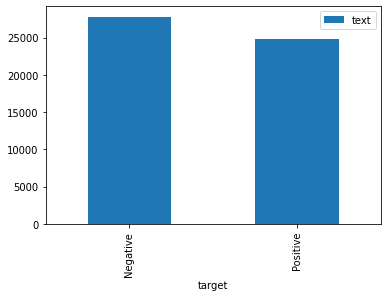

In [ ]:
# The distribution of sentiments
df_tweets.groupby('target').count().plot(kind='bar')

In [ ]:
import plotly.express as px

fig = px.pie(df_tweets, names='target', title ='Pie chart of different sentiments of tweets')
fig.show()

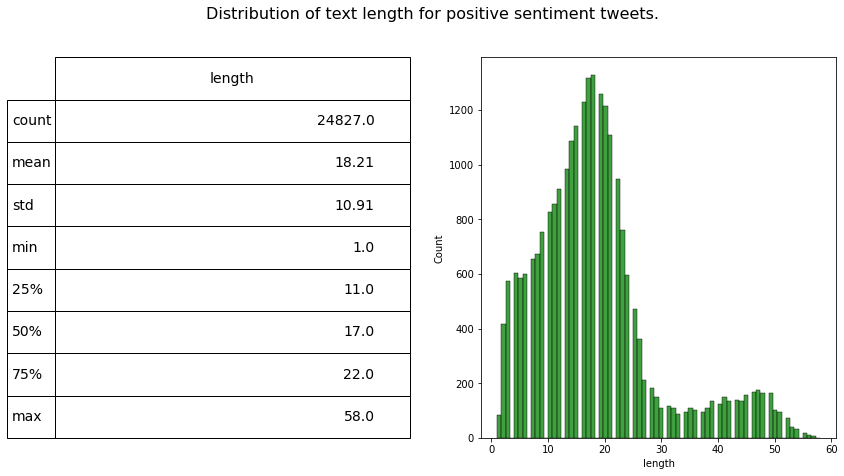

In [ ]:
#Distribution of text length of Postive tweets

fig = plt.figure(figsize=(14,7))
df_tweets['length'] = df_tweets.text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df_tweets[df_tweets['target']=='Positive']['length'], ax=ax1,color='green')
describe = df_tweets.length[df_tweets.target=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

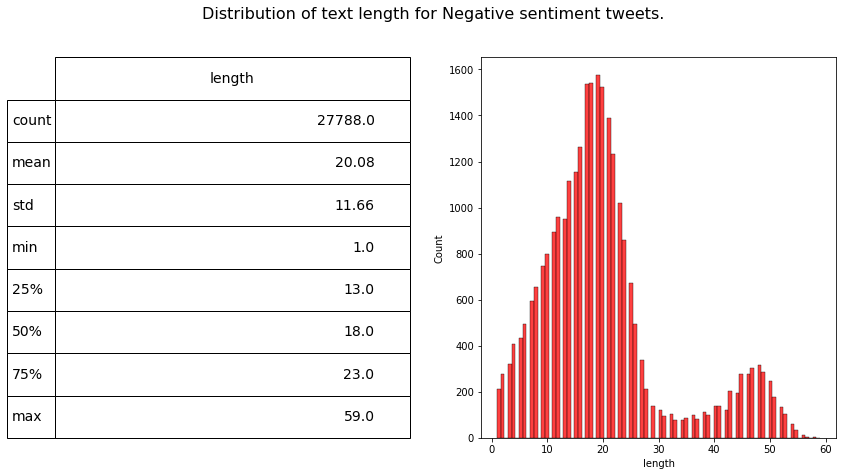

In [ ]:
#Distribution of text length of Negative tweets

fig = plt.figure(figsize=(14,7))
df_tweets['length'] = df_tweets.text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df_tweets[df_tweets['target']=='Negative']['length'], ax=ax1,color='red')
describe = df_tweets.length[df_tweets.target=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment tweets.', fontsize=16)

plt.show()

In [ ]:
df_tweets.drop(['length'], axis=1, inplace= True)
df_tweets.head()

,text,target
0,you have very c...,Negative
1,never learned so ...,Negative
2,if you buy the team i...,Negative
3,hey donald will ur new...,Negative
4,the only way to fix hea...,Negative


In [ ]:
from PIL import Image
from wordcloud import STOPWORDS, ImageColorGenerator

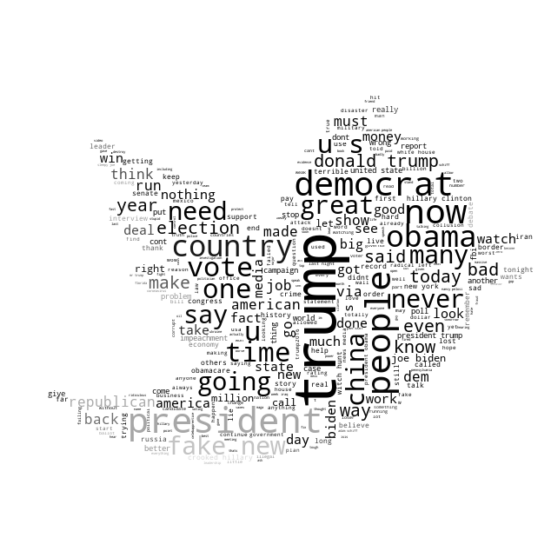

In [ ]:
# Visualizing negative tweets in a word cloud format
neg_tweets = df_tweets[df_tweets.target == "Negative"]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

stopwords=set(STOPWORDS)
more_stopwords= {'will', 'want'}
stopwords= stopwords.union(more_stopwords)

mask_image= np.array(Image.open('images/twitter_mask.jpg'))
wordcloud = WordCloud(background_color='white', max_words=2000, mask=mask_image, stopwords=stopwords).generate(neg_string)

fig= plt.figure()
fig.set_figwidth(14)
fig.set_figheight(10)
image_colors= ImageColorGenerator(mask_image)
wordcloud.recolor(color_func=image_colors)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file('images/neg_tweets_cloud.png')


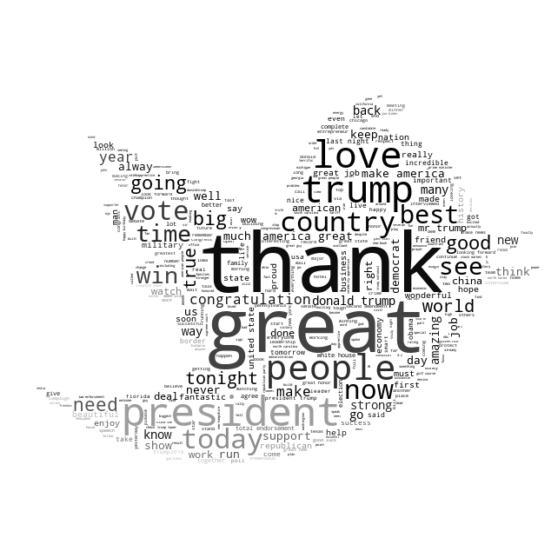

In [ ]:
# Visualizing positive tweets in a word cloud format
pos_tweets = df_tweets[df_tweets.target == "Positive"]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
    
pos_string = pd.Series(pos_string).str.cat(sep=' ')

stopwords=set(STOPWORDS)
more_stopwords= {'will', 'want', 'im', 'u', 's', 'die', 'amp', 'one'}
stopwords= stopwords.union(more_stopwords)

mask_image= np.array(Image.open('images/twitter_mask.jpg'))
wordcloud = WordCloud(background_color='white', max_words=2000, mask=mask_image, stopwords=stopwords).generate(pos_string)

fig= plt.figure()
fig.set_figwidth(14)
fig.set_figheight(10)
image_colors= ImageColorGenerator(mask_image)
wordcloud.recolor(color_func=image_colors)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file('images/positive_tweets_cloud.png')

In [ ]:

#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", df_tweets['text'][0])
print("\nProcessed tweet ->", tweet_to_words(df_tweets['text'][0]))


Original tweet ->                               you have  very capable kids that can run the company for you this country needs you badly    thx 

Processed tweet -> ['capabl', 'kid', 'run', 'compani', 'countri', 'need', 'badli', 'thx']


In [ ]:
X = list(map(tweet_to_words, df_tweets['text']))


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df_tweets['target'])

In [ ]:
print(X[0])
print(Y[0])

['capabl', 'kid', 'run', 'compani', 'countri', 'need', 'badli', 'thx']
0


In [ ]:
y = pd.get_dummies(df_tweets['target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) #split into test and validation set

In [ ]:
#Bag of words (BoW) extraction

from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

vocabulary_size = 5000

# Tweets have already been preprocessed hence dummy function will be passed in 
# to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 
#tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

In [ ]:
# print first 200 words/tokens
print(count_vector.get_feature_names()[0:200])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df_tweets['text'][0])
X, tokenizer = tokenize_pad_sequences(df_tweets['text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
                               you have  very capable kids that can run the company for you this country needs you badly    thx 
After Tokenization & Padding 
 [   9   22   42 3660 1597   14   68  105    1 1074    8    9   23   57
  267    9  505 1224    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [ ]:
#Saving tokenized data
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
y = pd.get_dummies(df_tweets['target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (31569, 50) (31569, 2)
Validation Set -> (10523, 50) (10523, 2)
Test Set -> (10523, 50) (10523, 2)


In [ ]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
# Bidirectional LSTM using NN
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



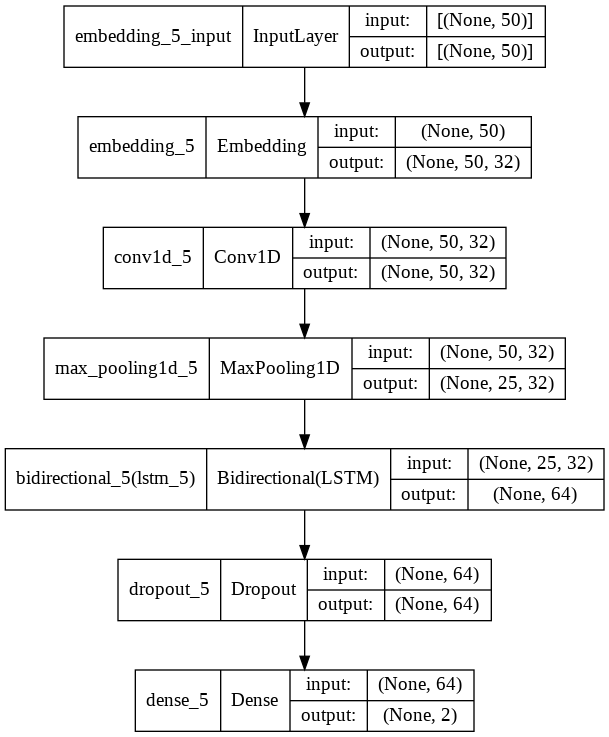

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 32)            160000    
                                                                 
 conv1d_5 (Conv1D)           (None, 50, 32)            2080      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 25, 32)           0         
 1D)                                                             
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                

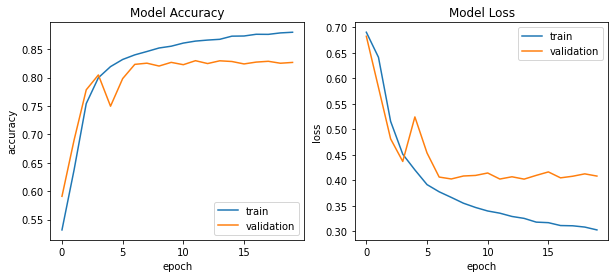

In [ ]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

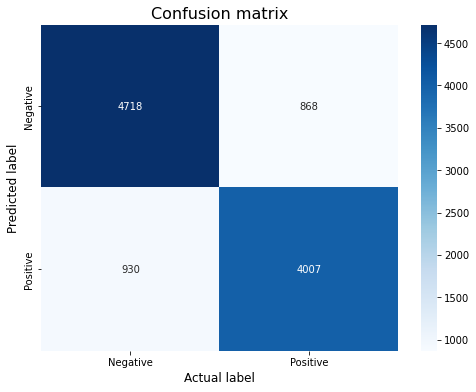

In [ ]:
#Model confusion matrix

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)

plot_confusion_matrix(model, X_test, y_test)

In [ ]:
# Save the model architecture & the weights
model.save('SC_Project/trump_lstm_model.h5')
print('Best model saved')

Best model saved


In [ ]:
from keras.models import load_model

# Load model
model = load_model('SC_Project/trump_lstm_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Negative', 'Positive']
    max_len=50
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [ ]:
predict_class(['"I hate when I have to call and wake people up'])


The predicted sentiment is Negative


In [ ]:
predict_class(['The food was stale'])


The predicted sentiment is Negative


In [ ]:
predict_class(['He is a best minister india ever had seen'])

The predicted sentiment is Positive


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
def get_top_n_trigram(corpus, n=None):
  vec = CountVectorizer(ngram_range=(3,3),stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]
common_words = get_top_n_trigram(df_tweets.text, 10)
trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

In [ ]:
trigram

,trigram,count
0,make america great,481
1,fake news media,257
2,complete total endorsement,235
3,crooked hillary clinton,133
4,new york times,128
5,president united states,104
6,radical left democrats,101
7,doing great job,92
8,sleepy joe biden,89
9,think like champion,82


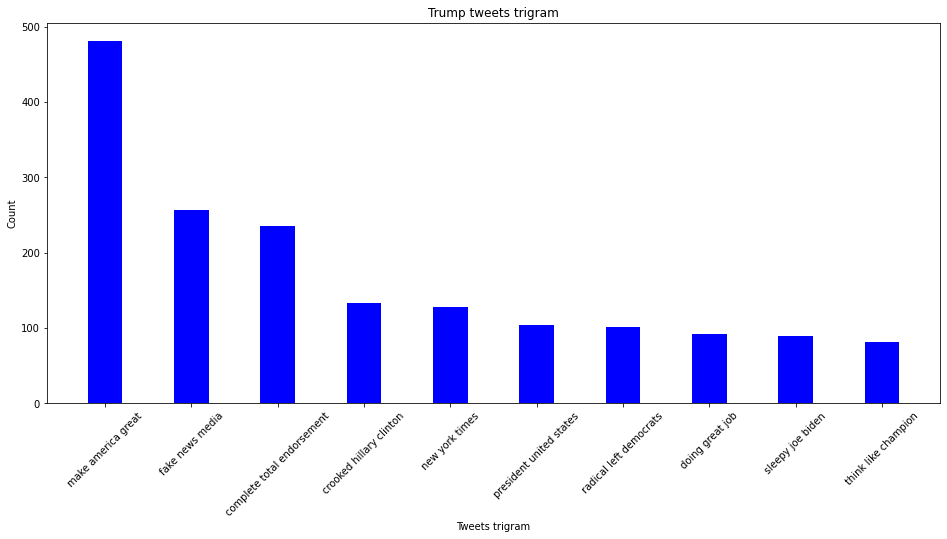

In [ ]:
fig= plt.figure(figsize=(16,7))

xaxis = trigram['trigram']
yaxis = trigram['count']
                         
plt.bar(xaxis, yaxis, width=0.4, color='blue')

plt.xlabel("Tweets trigram")
plt.ylabel("Count")
plt.title("Trump tweets trigram")
plt.xticks(rotation=45)
plt.show()

# **Topic Modeling**

In [ ]:
#create a document-term matrix to create vocabulary of all the words in tweets data
#Each of 52615 documents is represented as 5000 dimensional vectors, which means that our vocabulary has 5000 words.

from sklearn.decomposition import LatentDirichletAllocation
vectorizer = CountVectorizer(
analyzer='word',       
min_df=3,# minimum required occurences of a word 
stop_words='english',# remove stop words
lowercase=True,# convert all words to lowercase
token_pattern='[a-zA-Z0-9]{3,}',# num chars > 3
max_features=5000,# max number of unique words
                            )
data_matrix = vectorizer.fit_transform(df_tweets.text)
data_matrix

<52615x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 439759 stored elements in Compressed Sparse Row format>

In [ ]:
lda_model = LatentDirichletAllocation(
n_components=10, # Number of topics
learning_method='online',
random_state=20,       
n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_matrix)

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 4.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.7 MB 49.5 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=a332844c68a6325efcbddc063b4b50c0eaf10e3e07255b00f698cdfcf1052851
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompat

In [ ]:
# extract information from a fitted LDA topic model to inform an interactive web-based visualization

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_matrix, vectorizer, mds='tsne')

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/p

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2      32.420952   8.115230       1        1  12.357629
8       0.648955  71.707100       2        1  12.050119
5      71.019684   9.971006       3        1  11.023925
7       3.785981  33.185135       4        1  10.126591
4     -42.666500  -9.222070       5        1  10.104897
1      -3.621689 -43.526516       6        1   9.114990
0      -3.632402  -4.171708       7        1   9.063923
9     -36.584400  35.804413       8        1   8.926215
3      44.391380  50.615383       9        1   8.804760
6      40.235809 -31.591665      10        1   8.426952, topic_info=        Term         Freq        Total Category  logprob  loglift
1962   great  8581.000000  8581.000000  Default  30.0000  30.0000
4462   thank  3936.000000  3936.000000  Default  29.0000  29.0000
3253  people  3532.000000  3532.000000  Default  28.0000  28.0000
4607   trump  5983.000000  5983.000000  Default  27.0000  27.0000
2456    just  3312.000000  3312.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
87    action   206.307576   207.188869  Topic10  -5.2245   2.4695
1782  follow   204.528671   205.409986  Topic10  -5.2332   2.4694
3012     new  2322.049201  2707.476934  Topic10  -2.8037   2.3202
1354     don   608.283076   895.779581  Topic10  -4.1432   2.0867
4801    wait   214.026129   301.145179  Topic10  -5.1878   2.1322

[387 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
84        8  0.996933             act
87       10  0.994262          action
109       8  0.998423  administration
147       1  0.997416             ago
148       6  0.998551           agree
...     ...       ...             ...
4978      5  0.998998            year
4980      1  0.999376           years
4981      7  0.998010             yes
4982      3  0.997316       yesterday
4984     10  0.999078            york

[390 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 6, 8, 5, 2, 1, 10, 4, 7])

In [ ]:
#keep the top 10 most frequent words from each topic that found by LDA

for i,topic in enumerate(lda_model.components_):
  print(f'Top 10 words for topic #{i}:')
  print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
  print('\n')

Top 10 words for topic #0:
['tomorrow', 'trump', 'history', 'day', 'watch', 'president', 'tonight', 'china', 'today', 'country']


Top 10 words for topic #1:
['end', 'story', 'law', 'business', 'joe', 'dont', 'biden', 'strong', 'state', 'doing']


Top 10 words for topic #2:
['trade', 'republicans', 'hillary', 'did', 'got', 'border', 'fake', 'years', 'american', 'democrats']


Top 10 words for topic #3:
['come', 'enjoy', 'things', 'money', 'nice', 'true', 'election', 'world', 'time', 'thanks']


Top 10 words for topic #4:
['president', 'think', 'support', 'year', 'better', 'said', 'right', 'just', 'best', 'people']


Top 10 words for topic #5:


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['does', 'left', 'golf', 'maga', 'congratulations', 'military', 'bad', 'national', 'night', 'really']


Top 10 words for topic #6:
['soon', 'honor', 'happy', 'looking', 'forward', 'hard', 'total', 'deal', 'know', 'new']


Top 10 words for topic #7:
['working', 'stop', 'let', 'like', 'media', 'win', 'america', 'make', 'big', 'great']


Top 10 words for topic #8:
['work', 'states', 'want', 'vote', 'donald', 'good', 'president', 'great', 'trump', 'thank']


Top 10 words for topic #9:
['remember', 'makeamericagreatagain', 'endorsement', 'party', 'republican', 'trump', 'love', 'going', 'news', 'just']




In [ ]:
# the 9th topic looks like that of election campaign  as make america great again was election slogon of Trump

In [ ]:
#add a new created topic column to the input dataframe and assign to each row ,based on the probability value, the suitable topic. To 
#find the topic index with maximum value, we can call the argmax() method and pass 1 as the value for the axis parameter.

topic_values = lda_model.transform(data_matrix)
df_tweets['Topic'] = topic_values.argmax(axis=1)

In [ ]:
df_topic=df_tweets
df_topic

,text,target,Topic
0,you have very c...,Negative,6
1,never learned so ...,Negative,4
2,if you buy the team i...,Negative,7
3,hey donald will ur new...,Negative,5
4,the only way to fix hea...,Negative,9
...,...,...,...
52610,you've got something unique to offer find out...,Positive,7
52611,you've got something unique to offer find out...,Positive,7
52612,yvette herrell () is a proven fighter for new ...,Positive,2
52613,"zte, the large chinese phone company, buys a b...",Positive,7


In [ ]:
df_topic.to_csv('trump_tweets_with_topic.csv', index = False, encoding='utf-8')